In [611]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import humanize
import plotly.express as px

# Data For Good - Tax Observatory Dataviz

Visualizations for the EU Tax Observatory based on the [EU Tax Obs - Dataviz - Viz](https://docs.google.com/document/d/1q_7x8NrEWNsak9LSE3TxIiSphhVcqWqn6YeG1kQNQTk/edit#heading=h.97g77izer615) Google Docs.

## Table of contents
* [Initialization](#initialization)
* [#12 - available reports by company](#12---available-reports-by-company)
* [#13 - company key financials kpis](#13---company-key-financials-kpis)
* [#14 - company top jurisdictions for revenue](#14---company-top-jurisdictions-for-revenue)
* [#15 - company’s % pre-tax profit and % employees by jurisdiction](#15---companys--pre-tax-profit-and--employees-by-jurisdiction)
* [#18 - breakdown of revenue between related party and unrelated party in TH vs domestic vs non TH](#18---breakdown-of-revenue-between-related-party-and-unrelated-party-in-th-vs-domestic-vs-non-th)

## Initialization

In [612]:
# Import dataset in a DataFrame
df = pd.read_csv('data_final_dataviz.csv', sep=',')

In the website it will be possible to select a specific company. To work on the viz creation, we simulate the selection by picking a random company but also a random year.

In [613]:
# Select a random company and a random year
def pick_random_company_and_year() -> tuple:
    company = np.random.choice(df['mnc'].unique())
    print(f'Selected company : {company}.')

    year = np.random.choice(df.loc[df['mnc'] == company, 'year'].unique())
    print(f'Selected year : {year}.')

    return company, year

In [614]:
company, year = pick_random_company_and_year()
# company, year = 'SHELL', 2020

Selected company : ØRSTED.
Selected year : 2022.


## #12 - available reports by company

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|tbd (goal is on company page, to show reports tracked, so could be just a table showing year available for a company)|-||`company explo` need a filter by company||

In [615]:
def compute_company_available_reports(df: pd.DataFrame, company: str) -> dict:
    """Compute the number of reports tracked for a specific company and the 
    available fiscal years.

    Args:
        df (pd.DataFrame): CbCRs database.
        company (str): company name.

    Returns:
        dict: numbers of reports and fiscal years.
    """
    available_years = df.loc[df['mnc'] == company, 'year'].unique()
    n_reports = len(available_years)

    # Convert type of items from 'int' to 'str' in available years list
    years_string_list = [str(year) for year in available_years]
    
    # Summarize all available years in one string
    if len(years_string_list) == 1:
        years_string = years_string_list[0]
    elif len(years_string_list) > 1:
        years_string = ', '.join(years_string_list[:-1])
        years_string += ' and ' + years_string_list[-1]

    # Create a dictionnary with the results
    data = {
        'Company': company,
        'Reports': n_reports,
        'Fiscal year(s) available': years_string
    }

    return data


def display_company_available_reports(
        df: pd.DataFrame, company: str, hide_company: bool=True) -> pd.DataFrame:
    """Display the number of reports tracked for a specific company and the 
    available fiscal years.

    Args:
        df (pd.DataFrame): CbCRs database.
        company (str): company name.
        hide_company (bool, optional): hide company name in final table. Defaults to True.

    Returns:
        pd.DataFrame: numbers of reports and fiscal years.
    """
    
    # Compute data
    data = compute_company_available_reports(df=df, company=company)

    # Create the table
    df = pd.DataFrame.from_dict(data=data, orient='index')

    if hide_company:
        return df[1:].style.hide(axis='columns')

    return df.style.hide(axis='columns')

In [616]:
display_company_available_reports(df=df, company=company, hide_company=True)

Reports,3
Fiscal year(s) available,"2020, 2021 and 2022"


## #13 - company key financials kpis

**kpis** : hq country, total revenue, total unrelated party revenues, total related party revenues, pre-tax profits, taxes paid, employees.

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|raw figure for each, or table with indicator name in col A, value in col B|hq country : -<br><br>metrics : sum (metric) by year by mnc|**giulia : keep all values, even negative values**|`company explo` need a filter by company||

In [617]:
def compute_company_key_financials_kpis(
        df: pd.DataFrame, company: str, year: int=None) -> dict:
    """Compute key financial KPIs for a company.

    Args:
        df (pd.DataFrame): CbCRs database.
        company (str): Company name
        year (int, optional): fiscal year to filter the results with. Defaults to None.

    Returns:
        dict: company key financial KPIs.
    """
    
    kpis_list = ['total_revenues', 'unrelated_revenues', 'related_revenues', 
                 'profit_before_tax', 'tax_paid', 'employees']
    
    years_list = df.loc[df['mnc'] == company, 'year'].unique()

    # Compute sum of kpis
    if not year or year not in years_list:
        df = (df.loc[df['mnc'] == company]
            .groupby(['year', 'upe_name'], as_index=False)[kpis_list]
            .sum()
        )
    else:
        df = (df.loc[(df['mnc'] == company) & (df['year'] == year)]
              .groupby(['year', 'upe_name'], as_index=False)[kpis_list]
              .sum())

    df = df.set_index('year')

    # Make financial numbers easily readable with 'humanize' package
    for column in df.columns:
        if column not in ['employees', 'upe_name']:
            df[column] = df[column].apply(
                lambda x: humanize.intword(x) if isinstance(x, (int, float)) else x)
            df[column] = '€ ' + df[column]
        elif column == 'employees':
            df[column] = df[column].astype(int)

    # Clean columns string
    df = df.rename(columns={'upe_name': 'headquarter'})
    df.columns = df.columns.str.replace('_', ' ').str.capitalize()

    # Create a dictionnary with the results
    data = df.to_dict(orient='index')

    return data


def display_company_key_financials_kpis(
        df: pd.DataFrame, company: str, year: int=None) -> pd.DataFrame:
    """Display key financial KPIs for a company.

    Args:
        df (pd.DataFrame): CbCRs database.
        company (str): Company name
        year (int, optional): fiscal year to filter the results with. Defaults to None.

    Returns:
        pd.DataFrame: company key financial KPIs.
    """
    
    # Compute data
    data = compute_company_key_financials_kpis(df=df, company=company, year=year)

    # Create the table
    df = pd.DataFrame.from_dict(data)

    return df

In [618]:
display_company_key_financials_kpis(df=df, company=company)

,2020,2021,2022
Headquarter,Denmark,Denmark,Denmark
Total revenues,€ 9.3 billion,€ 14.4 billion,€ 23.2 billion
Unrelated revenues,€ 6.7 billion,€ 10.4 billion,€ 17.8 billion
Related revenues,€ 2.7 billion,€ 4.0 billion,€ 5.8 billion
Profit before tax,€ 2.3 billion,€ 1.8 billion,€ 2.4 billion
Tax paid,€ 150.0 million,€ 185.6 million,€ 169.8 million
Employees,6179,6836,8027


## #14 - company top jurisdictions for revenue

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal bar chart showing % total revenue for top 9 jurisdictions + rest as “OTHERS”|sum(revenue) by company x hq country x year, display top 9 and group remaining countries||`company explo` need a filter by company||

* Traiter les cas où il y a déjà une ligne other.
* calculer le revenue total si unrelated et related sont remplis mais pas total.
* Afficher qu'il n'y a pas d'informations disponible si graphique vide.

In [619]:
def compute_top_jurisdictions_revenue(
        df: pd.DataFrame=df, company: str=company, year:int=year) -> dict:
    
    df = df.loc[(df['mnc'] == company) & (df['year'] == year), ['jur_name', 'total_revenues']]
    df = df.fillna(0)
    df = df.sort_values(by='total_revenues', ascending=False)

    top = df[:9].copy()

    others = df[9:]['total_revenues'].sum()
    top.loc[9] = ['Others', others]

    top['total_revenues_%'] = top['total_revenues'] / top['total_revenues'].sum() * 100

    top = top.sort_values(by='total_revenues_%').reset_index(drop=True)

    data = top.to_dict()
    
    return data

In [620]:
pd.DataFrame(compute_top_jurisdictions_revenue())

,jur_name,total_revenues,total_revenues_%
0,Others,0.000000e+00,0.000000
1,Singapore,8.602613e+06,0.037129
2,Malaysia,2.889940e+07,0.124732
3,Poland,3.951825e+07,0.170563
4,Sweden,9.704823e+07,0.418866
5,United States of America,3.316038e+08,1.431224
6,Germany,4.958600e+08,2.140164
7,Taiwan,7.398247e+08,3.193131
8,United Kingdom,5.199473e+09,22.441260
9,Denmark,1.622843e+10,70.042931


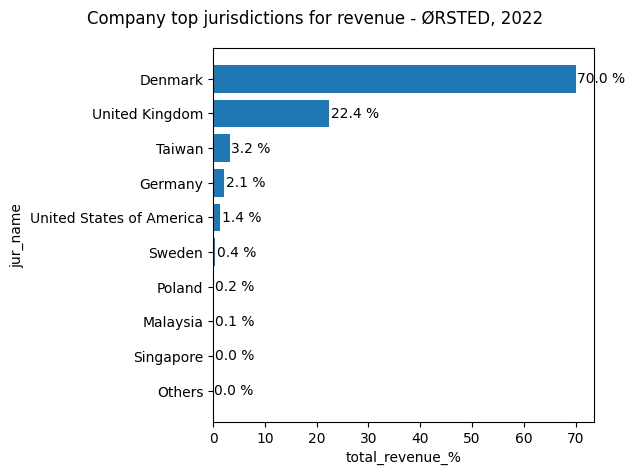

In [621]:
def plot_jurisdictions_top_revenue():

    top = pd.DataFrame(compute_top_jurisdictions_revenue())

    fig, ax = plt.subplots()
    bar = ax.barh(y=top['jur_name'], width=top['total_revenues_%'])

    ax.bar_label(bar, fmt='{:.1f} %', padding=1)

    ax.tick_params(axis='x', rotation=0)
    ax.set_xlabel('total_revenue_%')
    ax.set_ylabel('jur_name')

    fig.suptitle(f'Company top jurisdictions for revenue - {company}, {year}')

    plt.tight_layout()
    plt.show()

plot_jurisdictions_top_revenue()

## #15 - company’s % pre-tax profit and % employees by jurisdiction

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal bar chart with one bar for % pre tax profit, the other for % employees, in different colors rank by % pre-tax profit descending|for a company : filter (profit >0) profits by JUR / total profit vs employees by JUR / total employees|**giulia : keep only positive values**|`company explo` need a filter by company||

In [622]:
def compute_pretax_profit_and_employees_rank(
        df: pd.DataFrame=df, company: str=company, year: int=year) -> dict:
    
    df = df.loc[
        (df['mnc'] == company) & (df['year'] == year) & (df['profit_before_tax'] > 0), 
        ['jur_name', 'profit_before_tax', 'employees']
    ]

    # df = df.fillna(0)
    df = df.sort_values(by='profit_before_tax').reset_index(drop=True)

    df['profit_before_tax_%'] = df['profit_before_tax'] / df['profit_before_tax'].sum() * 100
    df['employees_%'] = df['employees'] / df['employees'].sum() * 100

    data = df.to_dict()

    return data

In [623]:
pd.DataFrame(compute_pretax_profit_and_employees_rank())

,jur_name,profit_before_tax,employees,profit_before_tax_%,employees_%
0,Poland,9.409108e+05,519.0,0.032605,7.257726
1,Singapore,2.822732e+06,13.0,0.097815,0.181793
2,Malaysia,3.225980e+06,574.0,0.111789,8.026849
3,France,3.629227e+06,51.0,0.125763,0.713187
4,Ireland,4.099683e+07,102.0,1.420653,1.426374
5,Netherlands,1.350879e+08,88.0,4.681168,1.230597
6,Germany,2.418141e+08,331.0,8.379524,4.628723
7,Denmark,1.129765e+09,4219.0,39.149471,58.998741
8,United Kingdom,1.327491e+09,1254.0,46.001211,17.536009


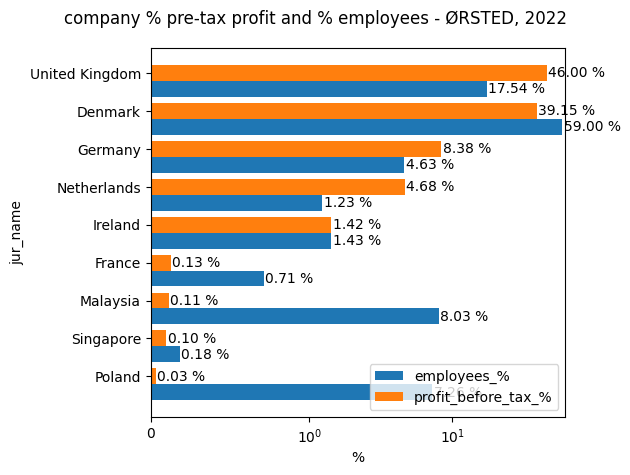

In [624]:
def plot_pretax_profit_and_employees_rank():

    rank = pd.DataFrame(compute_pretax_profit_and_employees_rank())

    jurisdictions = rank['jur_name'].values
    bar_width = 0.42
    bar_offsets = [-bar_width, 0, bar_width]

    fig_height = max(4.8, (0.48*len(jurisdictions)))
    fig, ax = plt.subplots(figsize=(6.4, fig_height))

    for i, (column, values) in enumerate(rank[['employees_%', 'profit_before_tax_%']].items()):
        bar_positions = []
        for j in range(len(jurisdictions)):
            bar_positions.append(j + bar_offsets[i])
        bars = ax.barh(bar_positions, values, height=bar_width, label=column)
        ax.bar_label(bars, fmt='{:.2f} %', padding=1)

    ax.set_xlabel('%')
    ax.set_yticks(range(len(jurisdictions)))
    ax.set_yticklabels(jurisdictions)
    ax.set_ylabel('jur_name')
    ax.set_xscale('symlog', linthresh=1)
    ax.legend(loc='lower right')
       
    fig.suptitle(f'company % pre-tax profit and % employees - {company}, {year}')

    plt.tight_layout()
    plt.show()

plot_pretax_profit_and_employees_rank()

## #18 - breakdown of revenue between related party and unrelated party in TH vs domestic vs non TH

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal barchart % of revenue from related-party revenue, and % revenue from unrelated party, show value for domestic (hq country) vs tax havens vs. non havens|get total revenue in TH, in domestic country, in non TH then show the % coming from unrelated party revenue and related party revenue (sum of both should equal total revenue)||`company explo` need a filter by company|what if sum or unrelated party revenue  and related party revenue does not equal to total revenue ? safeguard ?|

In [625]:
def compute_related_and_unrelated_revenues_breakdown(
        df: pd.DataFrame, company: str, year: int) -> dict:
    """Compute related and unrelated revenues in tax heaven, non tax heaven and
    domestic jusrisdictions.

    Args:
        df (pd.DataFrame): CbCRs database.
        company (str): Company name
        year (int): fiscal year to filter the results with.

    Returns:
        dict: revenues percentage for different type of jurisdictions.
    """
    
    # Create a filtered version of the dataset
    df_temp = df.loc[(df['mnc'] == company) & (df['year'] == year)].copy()

    # Create a boolean column to check if 'jur_code' is the domestic country
    df_temp['domestic'] = df_temp.apply(
        lambda row: row['jur_code'] == row['upe_code'], axis='columns')

    # Calculate missing values in 'related_revenues' if 'unrelated_revenues' and 'total_revenues' are available
    df_temp.loc[
        df_temp['unrelated_revenues'].notna() 
        & df_temp['total_revenues'].notna() 
        & df_temp['related_revenues'].isna(), 
        'related_revenues'
    ] = df_temp['total_revenues'] - df_temp['unrelated_revenues']

    # Calculate missing values in 'unrelated_revenues' if 'related_revenues' and 'total_revenues' are available
    df_temp.loc[
        df_temp['related_revenues'].notna() 
        & df_temp['total_revenues'].notna() 
        & df_temp['unrelated_revenues'].isna(), 
        'unrelated_revenues'
    ] = df_temp['total_revenues'] - df_temp['related_revenues']

    # Remove columns where 'unrelated_revenues' or 'related_revenues' is missing
    df_temp = df_temp.dropna(subset=['unrelated_revenues', 'related_revenues'])

    # Compute kpis in a new DataFrame
    data = pd.DataFrame()
    data['tax_haven'] = df_temp.loc[
        df_temp['jur_tax_haven'] == True, ['unrelated_revenues', 'related_revenues']].sum()
    data['non_tax_haven'] = df_temp.loc[
        df_temp['jur_tax_haven'] == False, ['unrelated_revenues', 'related_revenues']].sum()
    data['domestic'] = df_temp.loc[
        df_temp['domestic'] == True, ['unrelated_revenues', 'related_revenues']].sum()

    # Replace values with share (%) of 'unrelated/related revenues'
    data = data.div(data.sum(axis='rows'), axis='columns')

    # Convert DataFrame to dictionnary
    data = data.to_dict()

    return data


def display_related_and_unrelated_revenues_breakdown(
        df: pd.DataFrame, company: str, year: int):
    """Display related and unrelated revenues in tax heaven, non tax heaven and
    domestic jusrisdictions.

    Args:
        df (pd.DataFrame): CbCRs database.
        company (str): Company name
        year (int): fiscal year to filter the results with.
    """
    
    # Compute data
    data = compute_related_and_unrelated_revenues_breakdown(df=df, company=company, year=year)

    # Create DataFrame
    df = pd.DataFrame.from_dict(data, orient='index')

    # Rename columns and indexes
    df.columns = df.columns.str.replace('_', ' ').str.capitalize()
    df.index = df.index.str.replace('_', ' ').str.capitalize()
    
    # Create figure
    fig = px.bar(df, x=['Unrelated revenues', 'Related revenues'], y=df.index,
                  orientation='h', title='Breakdown of revenue', text_auto='.0%')

    # Update layout settings
    fig.update_layout(
        xaxis=dict(
            title=None,
            tickformat='.0%'
        ),
        yaxis_title=None,
        legend=dict(
            title=dict(text=''),
            orientation='h',
            y=1.1
        ),
        plot_bgcolor='white',
        width=800,
        height=480
    )

    # Define position of text values
    for col in ['Unrelated revenues', 'Related revenues']:
        
        values_positions = ['outside' if value <= 0.05 else 'inside' for value in df[col]]
    
        fig.update_traces(
            textangle=0,
            textposition=values_positions,
            selector=dict(name=col)
        )

    # Add annotation if no values are availables (no bar displayed)
    for i, index in enumerate(df.index):
        if df.loc[index].isna().all():
            fig.add_annotation(
                    x=0.5,
                    y=df.index[i],
                    text='Information not provided by the company',
                    showarrow=False,
                    font=dict(color='black', size=13)
                )
    
    # Define style of hover on bars
    fig.update_traces(hovertemplate='%{y}: %{x}')

    fig.show()

In [626]:
display_related_and_unrelated_revenues_breakdown(df=df, company=company, year=year)